## RNA Classification Part 2

Here, we're trying to create a dataset from the images obtained during the previous step. We're using a library called as 'Multilabelpigeon' that helps us labeling the images in an easier way

## Step 2: Creating the Dataset using the images

In [2]:
#!pip install multi-label-pigeon

In [4]:
#!pip install pigeon-jupyter

In [1]:
#Importing necessary libraries
import pandas as pd
import numpy as np
from fastai.vision import *

### Labeling the images, so that we avoid the false positives that are so certain.
#Unlike other cells, you can try executing this below **2 cells** alone to understand how the labeling is done. If there's an error, do try to install the libraries given in the first two cells

In [17]:
#Using multi label pigeon to label our data
from multi_label_pigeon import multi_label_annotate
from pigeon import annotate
from IPython.display import display, Image
images = []
path = 'train/'
for i in range(121,416):
    images.append(path + str('i')+str(i)+'.png')

annotations = annotate(images,
    options=['tRNA','miRNA','Neither'],
    display_fn=lambda filename: display(Image(filename))
    )

HTML(value='0 examples annotated, 296 examples left')

Output()

In [2]:
from multi_label_pigeon import multi_label_annotate
from IPython.display import display, Image
images = []
path = 'miRNA/folds/'
for i in range(0,176):
    images.append(path + str(i)+'.png')

annotations2 = annotate(images,
    options=['tRNA','miRNA','Neither'],
    display_fn=lambda filename: display(Image(filename))
    )

HTML(value='0 examples annotated, 177 examples left')

Output()

### Creating a dataframe from the image name and the labels

In [22]:
names = []
labels = []
for i in one_to_118:
    names.append(i[0].split('/')[-1])
    labels.append(i[1])

In [23]:
data = list(zip(names,labels))
df = pd.DataFrame(data, columns=['img', 'type'])

In [24]:
df.head()

,img,type
0,i0.png,miRNA
1,i1.png,Neither
2,i2.png,miRNA
3,i3.png,miRNA
4,i4.png,miRNA


In [40]:
names = []
labels = []
for i in o121toend:
    names.append(i[0].split('/')[-1])
    labels.append(i[1])

In [51]:
df['type'].value_counts()

miRNA      207
Neither    126
tRNA        82
Name: type, dtype: int64

In [52]:
a  = df.to_csv ('latest_labels.csv')

### Thus we have a dataset with images and labels, we can move on to building a model. 

# Step 3: Building the model

In [2]:
df = pd.read_csv('latest_labels.csv')

In [3]:
# Using the fast ai ImageDataBunch to get the data. Since we have the folder structure, not using the labels. But 
# in future, we could use the labels

In [4]:
path = 'train/'
np.random.seed(42)
data = ImageDataBunch.from_df(path,df=df, fn_col='img', label_col='type',  valid_pct=0.2,
                                  ds_tfms=get_transforms(),num_workers=0, size=256, bs=9)

In [5]:
#Look at the classes
data.classes

['Neither', 'miRNA', 'tRNA']

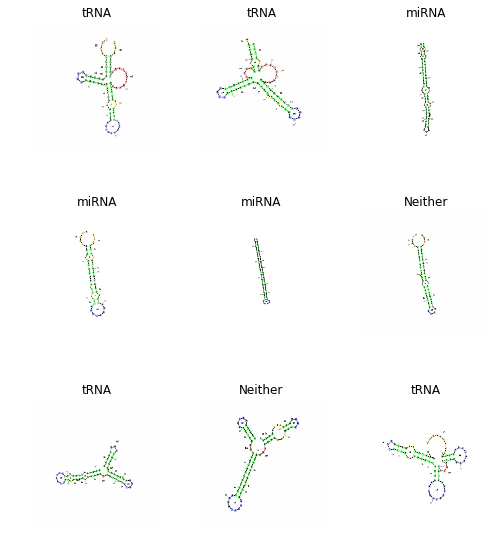

In [6]:
data.show_batch(rows=3, figsize=(7, 8))

In [7]:
#Using a pre trained model resnet (34 layer) we create a model
learn_resnet50=cnn_learner(data, models.densenet121, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /Users/rishikoushal/.cache/torch/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:01<00:00, 21.2MB/s]


In [8]:
learn_resnet50.freeze()

In [9]:
learn_resnet50.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


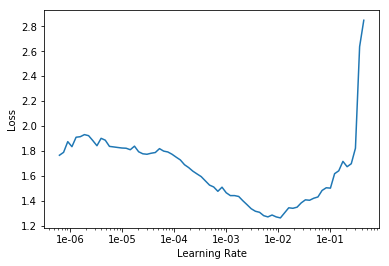

In [10]:
#We could see the curve for learning, which is not really smooth, but conisderable
learn_resnet50.recorder.plot()

In [11]:
#Fit one cycle on the data, with a specific learning rate range
lr=5e-4
learn_resnet50.fit_one_cycle(8, slice(lr/10, lr))

epoch,train_loss,valid_loss,accuracy,time
0,1.454567,1.316552,0.397590,04:33
1,1.112663,0.422602,0.831325,04:35
2,0.822612,0.255411,0.867470,04:35
3,0.711734,0.327021,0.891566,04:35
4,0.704110,0.307574,0.891566,04:36
5,0.662542,0.293207,0.891566,04:41
6,0.656156,0.278024,0.879518,04:38
7,0.631332,0.270655,0.891566,04:37


In [12]:
learn_resnet50.unfreeze()

In [13]:
lr=5e-4
learn_resnet50.fit_one_cycle(8, slice(lr/10, lr))

epoch,train_loss,valid_loss,accuracy,time
0,0.617506,0.344023,0.843373,05:10
1,0.630288,0.913713,0.843373,05:36
2,0.605449,0.211256,0.891566,05:20
3,0.641326,0.448971,0.843373,05:18
4,0.650479,0.357434,0.855422,05:19
5,0.568099,0.200988,0.939759,05:36
6,0.431686,0.245868,0.927711,05:24
7,0.416042,0.219576,0.927711,05:08


In [14]:
#Look for the confusion matrix and observe the false positives
interp=ClassificationInterpretation.from_learner(learn_resnet50)

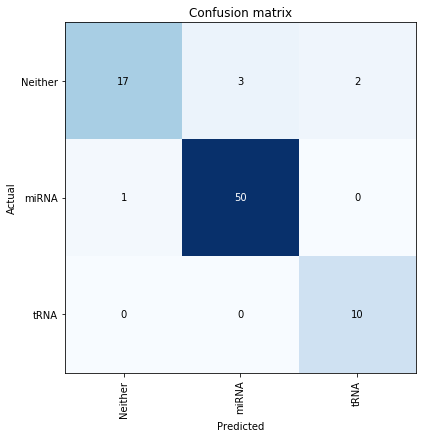

In [15]:
interp.plot_confusion_matrix(figsize=(6,6))

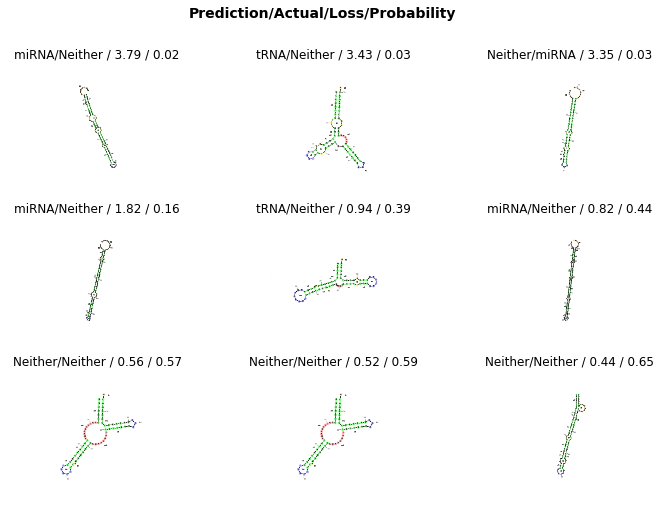

In [16]:
#Helps us to analyze how the model has performed
interp.plot_top_losses(k=9, figsize=(12, 8))

In [18]:
# We can update our dataset by removing some images
from fastai.widgets import *

ds, idxs = DatasetFormatter().from_toplosses(learn)
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

## Conclusion and Comments:

Though we obtained a fairly achievable model with ~90% accuracy, we face some problems in our data:

1. We can see that there are a lot of miRNA images, but a very little tRNA images. We can improve a lot, if we have some more tRNA sequences

2. We obtain the data from the gtrandb, who claim that there are some false positives in the sequence data. Thus, this could be a problem for us because when we fold those particular sequences, we won't get the clover shaped structure.

3. A lot of tRNA aren't looking like a clover shaped structure, which might be a problem that stops the model performing better.